In [1]:
import scipy.stats as sps
import matplotlib.pyplot as plt
import numpy as np
%pylab inline

Populating the interactive namespace from numpy and matplotlib


Часть 1. Устройство
===================

Загрузим в память выборку и посмотрим на неё.

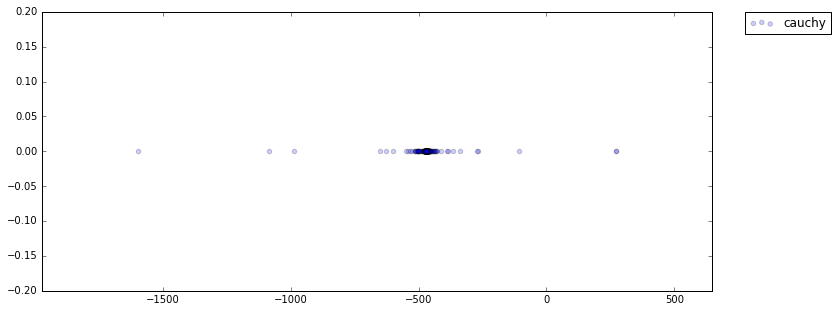

In [2]:
cauchy_sample = np.loadtxt(open("cauchy.txt"))

def draw_sample(sample, label, start, finish):
    plt.figure(figsize=(12, 5))
    plt.axis([start, finish, -0.2, 0.2])
    plt.scatter(sample, np.zeros(len(sample)), alpha=0.2, label=label)
    plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
    plt.show()

plot_delta = 0.2 * (cauchy_sample.max() - cauchy_sample.min());

draw_sample(cauchy_sample, "cauchy",
            cauchy_sample.min() - plot_delta, 
            cauchy_sample.max() + plot_delta)

Считать оценку методом максимального правдоподобия на всём интервале долго. Я попыталась это сделать, но ожидание затянулось. Поэтому воспользуемся тем, что медиана из распределения Коши совпадает с искомым параметром. Давайте посмотрим поближе, где сосредоточена большая часть значений.

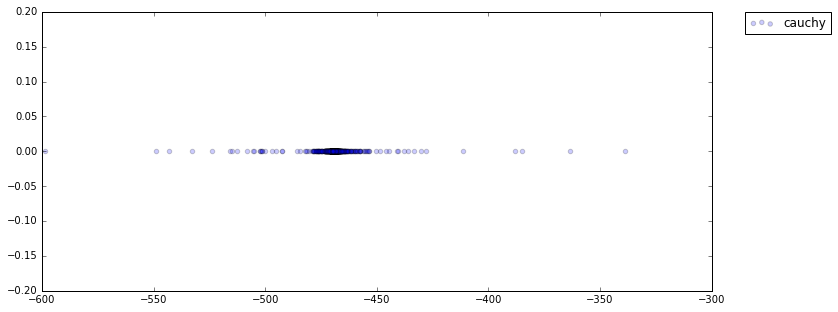

In [3]:
draw_sample(cauchy_sample, "cauchy",
            -600, 
            -300)

Из графика видно, что значение параметра стоит искать на интервале $[-500, -420]$, так как большая часть значений сосредоточена именно там (значит и медиана там же где-то).

Напишем функцию, которая ищет оценку методом максимального правдоподобия по заданным выборке **sample**, сетке **grid** и логарифму функции плотности **logpdf**. **logpdf** — это функция, которая принимает на вход два значения:

1. точку, в которой нужно посчитать логарифм плотности,
2. параметр распределения (тот самый который оцениваем).

In [4]:
class LnLikelihood:
    def calc_scalar(self, param):
        # считает логарифм функции правдоподобия для значения параметра param
        return self.logpdf(self.sample, param).sum()
    
    def __init__(self, sample, logpdf):
        self.sample = sample
        self.logpdf = logpdf
        # делаем calc_scalar применимой к np.array
        self.calc = np.vectorize(self.calc_scalar)
    
def param_by_mle(sample, logpdf, grid):
    ln_likelihood = LnLikelihood(sample, logpdf)
    return grid[ln_likelihood.calc(grid).argmax()]

Посчитаем оценки параметра.

In [5]:
# заворачиваем библиотечную функцию, чтобы передать нашей param_by_mle
def cauchy_logpdf(x, param):
    return sps.cauchy.logpdf(x, loc=param)

cauchy_grid = np.arange(-500, -420, 0.01) #шаг из условия, интервал пояснён выше

print("Для первой половины:", end=" ")
print(param_by_mle(cauchy_sample[:len(cauchy_sample) // 2], cauchy_logpdf, cauchy_grid))
print("Для всей выборки:", end=" ")
print(param_by_mle(cauchy_sample, cauchy_logpdf, cauchy_grid))

Для первой половины: -469.24
Для всей выборки: -469.15


Заметим, что полученные оценкци не сильно отличаются от тех, которые насчитала библиотечная функция. В частности, это подтверждает, что интервал для поиска был выбран правильно.

In [6]:
print("Для первой половины:", end=" ")
print(sps.cauchy.fit(cauchy_sample[:len(cauchy_sample) // 2], fscale=1)[0])
print("Для всей выборки:", end=" ")
print(sps.cauchy.fit(cauchy_sample, fscale=1)[0])

Для первой половины: -469.237787141
Для всей выборки: -469.153233563


Часть 2. Банк
=============

Загрузим в память выборку и посмотрим на неё. Ничего не понятно, ну ок.

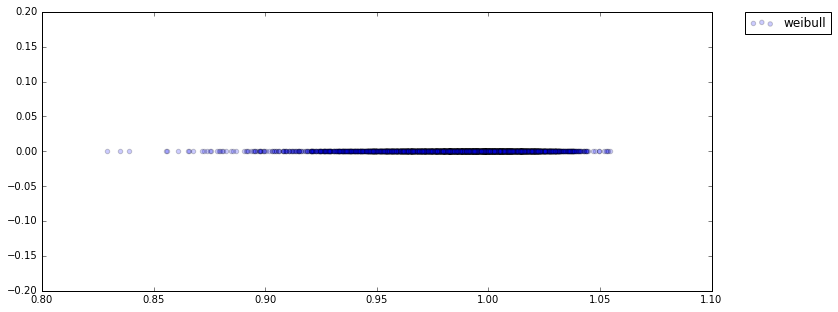

In [7]:
weibull_sample = np.loadtxt(open("weibull.txt"))
draw_sample(weibull_sample, "weibull", 0.8, 1.1)


Применим ту же самую функцию, чтобы оценить параметр распределения Вейбулла.

In [8]:
# Такое же заворачивание, как для Коши.
# Можно заметить, что я просто привожу к общему виду
# передачу параметра в распределение.
def weibull_logpdf(x, param):
    return sps.weibull_min.logpdf(x, c=param)

#В условии требовалось взять шаг 1e-3 на логарифмической шкале от -2 до 2
#Именно это я тут и делаю
weibull_grid = np.logspace(-2, 2, num=4001) 

print("Для первых 4-х лет:", end=" ")

#Учитываем високосный год. В условии за 10 лет измерений было 2 високосных года.
#Среди 4-х подряд идущих лет обязательно есть високосный.
n_days_in_4_years = 365 * 4 + 1 

print(param_by_mle(weibull_sample[:n_days_in_4_years], weibull_logpdf, weibull_grid))
print("Для всей выборки:", end=" ")
print(param_by_mle(weibull_sample, weibull_logpdf, weibull_grid))

Для первых 4-х лет: 42.364296605
Для всей выборки: 41.9758983991


Получим результат, который не сильно отличается от оценки библиотечной функцией.

In [9]:
print("Для первых 4-х лет:", end=" ")
print(sps.weibull_min.fit(weibull_sample[:n_days_in_4_years], fscale=1, floc=0)[0])
print("Для всей выборки:", end=" ")
print(sps.weibull_min.fit(weibull_sample, fscale=1, floc=0)[0])

Для первых 4-х лет: 42.3385742188
Для всей выборки: 42.0044921875
